In [1]:
#The data below has been imported from the COVID 19 India patient database from the following sources:
#1.https://github.com/dishamakhija/covid19-india/blob/master/data/time_series_covid19_confirmed_India_20200410.csv
#2.https://docs.google.com/spreadsheets/d/e/2PACX-1vSz8Qs1gE_IYpzlkFkCXGcL_BqR8hZieWVi-rphN1gfrO3H4lDtVZs4kd0C3P8Y9lhsT1rhoB-Q_cP4/pubhtml
#Both data sources have  a count of  total number of COVID 19 cases in India,which using a PowerLaw model,
#the code takes the data from the previous week and predicts the number of cases for the upcoming week.
#The graphs from this code is put up on my website @ https://sites.google.com/site/sohamdasgupta04.
import matplotlib
import lmfit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import LorentzianModel, ExponentialModel, PowerLawModel
from numpy import linspace
plt.close('all')
from pprint import pprint
from datetime import timedelta, date

In [2]:
last_k = 7
df_us = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
df_india = pd.read_csv("data/indiatotalupdated.csv")

In [3]:
df_us.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [4]:
df_india

,Country/Region,10-03-2020,11-03-2020,12-03-2020,13-03-2020,14-03-2020,15-03-2020,16-03-2020,17-03-2020,18-03-2020,...,09-04-2020,10-04-2020,11-04-2020,12-04-2020,13-04-2020,14-04-2020,15-04-2020,16-04-2020,17-04-2020,Unnamed: 40
0,India,47,60,73,82,84,110,114,137,151,...,6725,7600,8504,9206,10453,11487,12370,13430,14352,NaN


Transform India data : Since we iterate over dates, it is easier to have dates as rows instead of columns 
------------------

In [5]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2020, 3, 10)
end_dt = date(2020, 4, 16)
analysis_dates = []
for dt in daterange(start_dt, end_dt):
    analysis_dates.append(dt.strftime("%Y-%m-%d"))

In [6]:
analysis_dates

['2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-05',
 '2020-04-06',
 '2020-04-07',
 '2020-04-08',
 '2020-04-09',
 '2020-04-10',
 '2020-04-11',
 '2020-04-12',
 '2020-04-13',
 '2020-04-14',
 '2020-04-15',
 '2020-04-16']

In [7]:
df_india

,Country/Region,10-03-2020,11-03-2020,12-03-2020,13-03-2020,14-03-2020,15-03-2020,16-03-2020,17-03-2020,18-03-2020,...,09-04-2020,10-04-2020,11-04-2020,12-04-2020,13-04-2020,14-04-2020,15-04-2020,16-04-2020,17-04-2020,Unnamed: 40
0,India,47,60,73,82,84,110,114,137,151,...,6725,7600,8504,9206,10453,11487,12370,13430,14352,NaN


In [8]:
# Transform India data
india_data = []

for index, row in df_india.iterrows():
    i=1
    for d in analysis_dates:
        data_point = {
            
            'date' : d,
            'cases' : row[i],
            'Country':row[0]     
        }
        i=i+1
        india_data.append(data_point)

df_india_transform = pd.DataFrame(india_data)


In [9]:
df_india_transform

,date,cases,Country
0,2020-03-10,47,India
1,2020-03-11,60,India
2,2020-03-12,73,India
3,2020-03-13,82,India
4,2020-03-14,84,India
5,2020-03-15,110,India
6,2020-03-16,114,India
7,2020-03-17,137,India
8,2020-03-18,151,India
9,2020-03-19,173,India


In [10]:
df_india_transform

,date,cases,Country
0,2020-03-10,47,India
1,2020-03-11,60,India
2,2020-03-12,73,India
3,2020-03-13,82,India
4,2020-03-14,84,India
5,2020-03-15,110,India
6,2020-03-16,114,India
7,2020-03-17,137,India
8,2020-03-18,151,India
9,2020-03-19,173,India


In [11]:
df_india


,Country/Region,10-03-2020,11-03-2020,12-03-2020,13-03-2020,14-03-2020,15-03-2020,16-03-2020,17-03-2020,18-03-2020,...,09-04-2020,10-04-2020,11-04-2020,12-04-2020,13-04-2020,14-04-2020,15-04-2020,16-04-2020,17-04-2020,Unnamed: 40
0,India,47,60,73,82,84,110,114,137,151,...,6725,7600,8504,9206,10453,11487,12370,13430,14352,NaN


Total number of cases for each date
--

In [12]:
df_india_transform[df_india_transform['Country'] == 'India']

,date,cases,Country
0,2020-03-10,47,India
1,2020-03-11,60,India
2,2020-03-12,73,India
3,2020-03-13,82,India
4,2020-03-14,84,India
5,2020-03-15,110,India
6,2020-03-16,114,India
7,2020-03-17,137,India
8,2020-03-18,151,India
9,2020-03-19,173,India


Generate plots
---

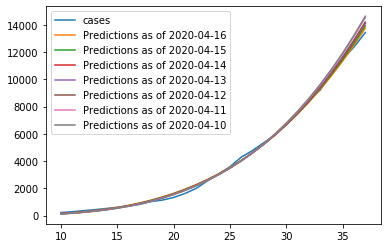

In [13]:
def label(l, df):
    return 'Predictions as of ' + str(df.date[l-1])


def generate_prediction_plot(df):
    model = PowerLawModel()
    params = model.guess(df.cases, x=df.cases.index)
    last = len(df)
    answers = {}
    for i in range(last_k):
        ind = last-i
        answers[i]= {'label': label(ind, df), 'model': model.fit(df.cases[:ind], params, x=df.cases.index[:ind])}
        df[label(ind, df)] = list(map(lambda x: int(x), answers[i]['model'].eval(x=df.cases.index)))
    return df[['cases'] + [label(last-i, df) for i in range(last_k)]][10:].plot()


def get_plots(Country):
    df_india_transform_e = df_india_transform[df_india_transform.Country == Country]
    ind_Country = df_india_transform_e.reset_index()
    return generate_prediction_plot(ind_Country)


plot = get_plots('India')
fig = plot.get_figure()
fig.savefig("16april.jpeg")
plot